<div class='alert alert-success'>
    <h1>Examples using Qiskit </h1>
    <h4>Yen Lee Loh; started 2023-4-5, edited 2023-4-7 </h4>
</div>

<div class="alert alert-info"><h2>  Setup  </h2></div>

This is a Markdown cell with LaTeX definitions.  Please run it.
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$

In [1]:
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()

def toBitString(integer, numBits): return bin(integer)[2:].zfill(numBits)
def plotStateVector(psi,ax,cmap=mpl.cm.hsv):
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  for l in range(lmax):
    patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
    ax.add_patch(patch)
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, max(probs)*1.1)
def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {toBitString(i,n):sanitize(cts.get(toBitString(i,n))) for i in range(2**n)}
def plotHistogram(counts,ax,fc='#9cf',textrot=0):
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )  # ugly
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  ymax = max(counts)
  for l in range(lmax):
    c = counts[l]
    patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
    ax.add_patch(patch)
    if c>0:
      y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
      ax.text (l+.5, y, c, va='center',ha='center')
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])  
  ax.tick_params(axis='x', labelrotation=textrot)
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, ymax*1.02)

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator

#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine

<div class="alert alert-info"><h2>  Hamiltonian time evolution of 3-site hard-core boson model  </h2></div>

Consider a model with three orbitals of energies $V_0$, $V_1$, and $V_2$.  Each orbital may be occupied by either 0 or 1 bosons.  If two bosons are in orbitals 0 and 1, they make a repulsive energy contribution $V_{01}$ to the system.  A boson may hop between orbitals with amplitudes $J_{01}$ and $J_{12}$.  We can simulate the time evolution for timestep $t$ using the quantum circuit below:

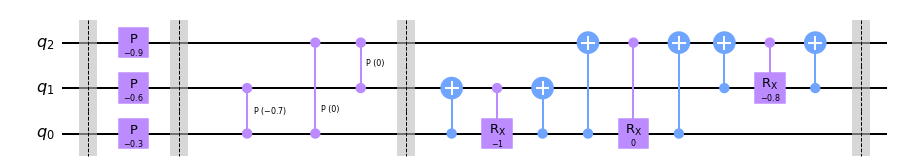

In [7]:
[V0,V1,V2] = np.array([3,6,9])
[V01,V02,V12] = np.array([7,0,0])
[J01,J02,J12] = np.array([5,0,4])
def evolveByTimeStep (cir, t):
  cir.barrier()
  #======== Apply phase gates to each qubit
  cir.p(-V0*t, 0)  # state evolves by phase factor exp(-i E0 t) if orbital 0 is occupied
  cir.p(-V1*t, 1)
  cir.p(-V2*t, 2)
  cir.barrier()
  #======== Apply controlled phase gates representing each orbital-orbital interaction
  cir.cp(-V01*t, 0,1)  # state evolves by exp(-i V01 t) if orbitals 0 and 1 are both occupied
  cir.cp(-V02*t, 0,2)
  cir.cp(-V12*t, 1,2)
  cir.barrier()
  #======== Apply gate sequences representing orbital-orbital boson hopping
  i,j=0,1; cir.cx(i,j); cir.crx(-2*J01*t, j,i); cir.cx(i,j);
  i,j=0,2; cir.cx(i,j); cir.crx(-2*J02*t, j,i); cir.cx(i,j);
  i,j=1,2; cir.cx(i,j); cir.crx(-2*J12*t, j,i); cir.cx(i,j);
  cir.barrier()
cir = qiskit.QuantumCircuit(3)
evolveByTimeStep (cir, 0.1)
display(cir.draw('mpl',reverse_bits=True))

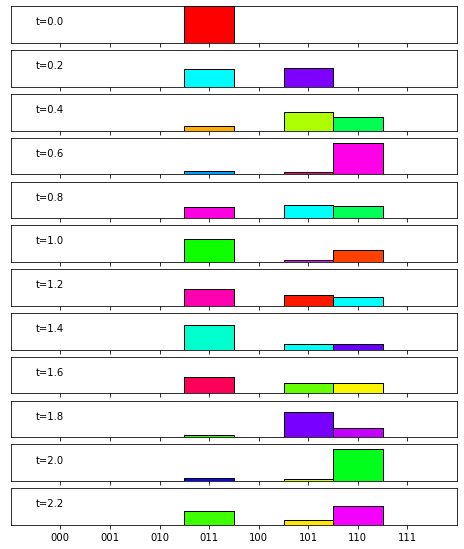

In [3]:
tStep = 0.2
numFigs = 12
fig,axs = plt.subplots(numFigs,1,figsize=(8,numFigs*1))
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
for numTimesteps in range(numFigs):
  #======== Start with two bosons in orbitals 0 and 1 (i.e., q0=1, q1=1, q2=0)
  cir = qiskit.QuantumCircuit(3)
  cir.x(0)
  cir.x(1)
  t = 0
  for timestep in range(numTimesteps): evolveByTimeStep (cir, tStep); t+=tStep
  cir.save_statevector()
  psi = np.asarray(sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir))
  ax = axs[numTimesteps]
  plotStateVector (psi,ax=ax); ax.set_ylim (0,1); ax.text (0, .5, f't={t:.1f}'); ax.set_yticks([])
fig.subplots_adjust(bottom=0.0,top=.6)

The figure above shows the statevector as a function of time, $\ket{\Psi(t)} = e^{-i\hat{H}t} \ket{\Psi(0)}$, calculated using lowest-order Trotterization with a timestep $\tau=0.2$.  The simulation is initialized with $\ket{\Psi(0)} = \ket{011}$, with 2 bosons in the 2 lowest-energy orbitals.  (Note that the basis states are labeled $\ket{n_2n_1n_0}$!)  As the time $t$ increases, bosons hop to higher-energy orbitals, so $\ket{\Psi(t)}$ has some contribution from the excited configurations $\ket{101}$ and $\ket{110}$.

In a real application, one cannot read out the state vector.  Rather, one measures the qubits (in the standard basis).  This is equivalent to measuring the $Z$ components of the qubit spins.  One obtains $n_2$, $n_1$, and $n_0$ simultaneously.

<div class="alert alert-info"><h2>  Quantum phase estimation  </h2></div>

<div class="alert alert-warning"><h3>  Quantum phase estimation for $N=5$ and $M=1$  </h3></div>

In this example, $U = P(2\pi \times 10.57/32)$ is a phase gate that rotates by 10.57/32 of a complete cycle.  The circuit below implements Quantum Phase Estimation (QPE) to find an eigenvalue of U.

None

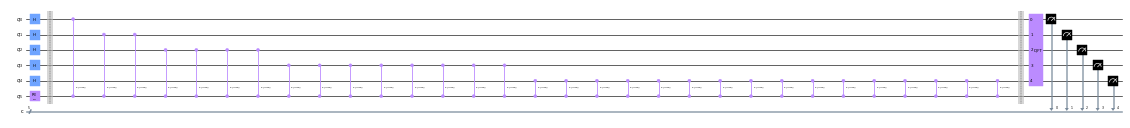

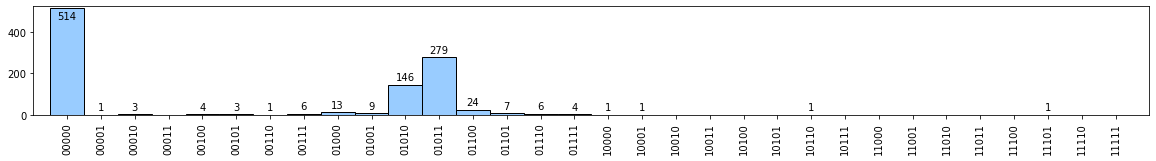

In [10]:
freq = 10.57/32
nmax = 5
mmax = 1
def applyCU(cir, n, mList):  cir.cp(2*np.pi*freq, n, mList[0])
#======== Set up circuit
mList = [nmax]
cir = qiskit.QuantumCircuit(nmax+mmax, nmax)
for n in range(nmax): cir.h(n)     # Set up "time" register with initial Hadamard gates
cir.rx(1.6, mList[0])             # Set up "state" register with guess at eigenvector
cir.barrier()
for n in range(nmax):
  for i in range(2**n): 
    applyCU (cir, n, mList)        # Controlled unitary gates
cir.barrier()
cir.append(qiskit.circuit.library.QFT(nmax).inverse(), range(nmax)) # Quantum Fourier transform
cir.measure(range(nmax), range(nmax))
fig,ax = plt.subplots(figsize=(20,6))
display(cir.draw('mpl',justify='left',fold=-1,ax=ax))
#======== Run simulation and plot histogram of results
sim = qiskit_aer.AerSimulator()
cts = sim.run(qiskit.transpile(cir,sim)).result().get_counts(cir)
fig,ax = plt.subplots(figsize=(20,2))
plotHistogram(cts, ax=ax, textrot=90)

QPE reveals that the two dominant frequencies are $f_0 = 0$ and $f_1 = 11/32$.  These numbers are indeed close to the eigenvalues of the phase gate, which are 0 and 10.57/32.

<div class="alert alert-warning"><h3>  Quantum phase estimation for $N=5$ and $M=3$  </h3></div>

Now suppose the unitary time-evolution operator happens to be a cyclic permutation,

$\hspace{1cm}$$\underline{\underline{\mathbf{U}}} = \text{SWAP}_{21} \text{SWAP}_{10} = \pmatrix{0&1&0\\0&0&1\\1&0&0}$.

It is well known that the eigenvalues of this operator are the three roots of unity,

$\hspace{1cm}$$\lambda = 1, e^{2\pi i/3}, e^{-2\pi i/3}$.

So we expect the frequencies to be $0$, $1/3$, and $2/3$.  We can implement a controlled version of our U operator, CU, by replacing each SWAP gate into a CSWAP gate.  Let's see what happens when we do QPE:

None

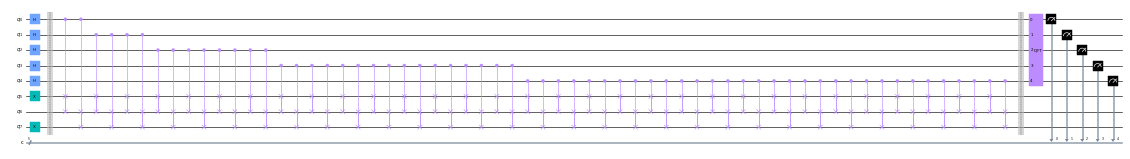

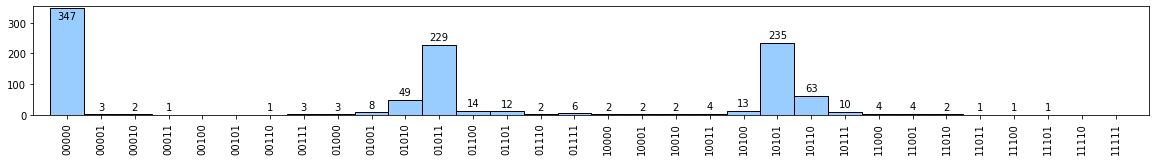

In [11]:
def applyCU(cir, n, mList):
  cir.cswap(n, mList[0], mList[1])
  cir.cswap(n, mList[1], mList[2])
nmax = 5
mmax = 3
#======== Set up circuit
mList = list(range(nmax,nmax+mmax))
cir = qiskit.QuantumCircuit(nmax+mmax, nmax)
# cir = qiskit.QuantumCircuit(nmax+mmax, nmax+mmax)
for n in range(nmax): cir.h(n)     # Set up "time" register with initial Hadamard gates

cir.x(mList[0]); cir.x(mList[2])
# Set up "state" register with guess at eigenvector

cir.barrier()
for n in range(nmax):
  for i in range(2**n): 
    applyCU (cir, n, mList)        # Controlled unitary gates
cir.barrier()
cir.append(qiskit.circuit.library.QFT(nmax).inverse(), range(nmax)) # Quantum Fourier transform
cir.measure(range(nmax), range(nmax))
# cir.measure(range(nmax+mmax), range(nmax+mmax))
fig,ax = plt.subplots(figsize=(20,6))
display(cir.draw('mpl',justify='left',fold=-1,ax=ax))
#======== Run simulation and plot histogram of results
sim = qiskit_aer.AerSimulator()
cts = sim.run(qiskit.transpile(cir,sim)).result().get_counts(cir)
fig,ax = plt.subplots(figsize=(20,2))
plotHistogram(cts, ax=ax, textrot=90)

QPE gives a frequency spectrum with three peaks, corresponding to the eigenvalues discussed above!

<div class="alert alert-warning"><h3>  Quantum phase estimation for Hamiltonian time evolution?  </h3></div>

Can one take the circuit from "Hamiltonian time evolution of 3-site hard-core boson model" and plug it into the "Quantum phase estimation" algorithm?

Unfortunately, this is quite challenging.  Look back at the Hamiltonian time evolution code where it says

    def evolveByTimeStep(...):

That code contains four types of gates: phase gates (p), controlled phase gates (cp), controlled NOT (cx), and controlled X rotation (crx).

If you want to plug this into QPE, you need to convert each of those gates into a controlled version:

    p   --> cp
    cp  --> ccp
    cx  --> ccx
    crx --> ccrx

Qiskit only supplies cp and ccx.  It does not supply ccp and ccrx.  You would need to build these gates yourself, or look for them in the Qiskit Circuit Library.  See https://qiskit.org/documentation/stable/0.19/apidoc/circuit_library.html 

<div class="alert alert-info"><h2>  Variational quantum eigensolver  </h2></div>

<div class="alert alert-warning"><h3>  Toy problem with 2 bosons in 3 orbitals: description  </h3></div>

Consider the hard-core boson Hamiltonian 

$\hspace{1cm}$$\hat{H} = \sum_i \xi_i \hat{n}_i + \sum_{ij} V_{ij} \hat{n}_i \hat{n}_j - \sum_{ij} J (\hat{a}^\dagger_i a_j + h.c.)$.

Represent boson states by qubit states as follows:

$\hspace{1cm}$$\begin{align}
    \ket{        \bullet} = \ket{n_\text{boson}=0}  &= \ket{x_\text{qubit}=0} = \ket{\uparrow}   = \ket{S^Z_\text{qubit}=+1}  \\
    \ket{\phantom\bullet} = \ket{n_\text{boson}=1}  &= \ket{x_\text{qubit}=1} = \ket{\downarrow} = \ket{S^Z_\text{qubit}=-1}  .
    \end{align}$

Map the boson operators on each site to qubit-spin operators as follows:

$\hspace{1cm}$$\begin{align}
    \hat{n}         &= \tfrac{1}{2} - \hat{S}^Z \\
    \hat{a}         &= \hat{S}^+ = \hat{S}^X + i \hat{S}^Y \\
    \hat{a}^\dagger &= \hat{S}^- = \hat{S}^X + i \hat{S}^Y .
    \end{align}$
    
To apply the VQE, let us use a trial state of the form

$\hspace{1cm}$$\begin{align}
    \ket{\psi} &=
        e^{ i\beta_{12} (a_1^\dagger a_2 + a_2^+ a_1) }
        e^{ i\beta_{02} (a_0^+ a_2 + a_2^+ a_0) }
        e^{ i\beta_{01} (a_0^+ a_1 + a_1^+ a_0) }
        \ket{011}
        ,\\
    \ket{011} &= \adag_1 \adag_0 \ket{000}
        .
    \end{align}$
 
Note that two-qubit partial-swap operations can be implemented in terms of CX (controlled X) gates and CRX (controlled X-rotation) gates:

$\hspace{1cm}$$\begin{align}
    e^{ i\beta_{ij} (a_i^+ a_j + a_j^+ a_i) } &= \hat{X}_{ij} \hat{R}^X_{ji} ({2\beta t}) \hat{X}_{ij}
        .
    \end{align}$
        

We wish to find the ground-state energy and statevector of the Hamiltonian.  Do it using the VQE as follows.
- Define the parameters in the Hamiltonian, such as orbital energies $\{\xi_i\}$, repulsion strengths $\{V_{ij}\}$, and hopping amplitudes $\{J_{ij}\}$
- Choose variational parameters $\{\beta_{01},\beta_{02},\beta_{12}\}$
- Repeat the following:
    - Repeat the following 1000 times:
        - Initialize statevector to $\ket{000}$
        - Apply 1-qubit X gates to get $\ket{011} = \hat{X}_1 \hat{X}_0 \ket{000}$
        - Apply 2-qubit partial swaps to get trial state $\ket{\psi}$
        - Measure all qubits to obtain $(n_2,n_1,n_0)$ where $\mean{\hat{n}_i} = \frac{1}{2} + \frac{1}{2} \mean{\hat{Z}_i}$
    - Repeat the following 1000 times:
        - Prepare trial state as before and apply Hadamard gates to get $\hat{H}_2\hat{H}_1\hat{H}_0\ket{\psi}$
        - Measure all qubits to obtain $(X_2,X_1,X_0)$ where $\mean{\hat{n}_i} = \frac{1}{2} + \frac{1}{2} \mean{\hat{X}_i}$
    - Repeat the following 1000 times:
        - Prepare trial state as before and apply inverse-S and H gates: $\hat{H}_2\hat{H}_1\hat{H}_0\hat{S}^\dagger_2\hat{S}^\dagger_1\hat{S}^\dagger_0\ket{\psi}$
        - Measure all qubits to obtain $(Y_2,Y_1,Y_0)$ where $\mean{\hat{n}_i} = \frac{1}{2} + \frac{1}{2} \mean{\hat{Y}_i}$
    - Compute averages $\mean{n_i}$ and correlations $\mean{n_in_j}$
    - Calculate on-site energy $\sum_i \xi_i \langle n_i \rangle$ and interaction energy $\sum_{\langle ij \rangle} J_{ij} \langle n_in_j \rangle$ 
    - Calculate hopping energy $\sum_{\langle ij \rangle} J_{ij} \langle X_iX_j + Y_iY_j \rangle$ 
    - Record total energy as $E_\text{trial} (\beta_{01},\beta_{02},\beta_{12})$
    - If convergence criteria are satisfied, return energy $E_\text{trial}$ and parameters $(\beta_{01},\beta_{02},\beta_{12})$
    - Otherwise, modify parameters and go back to beginning of loop

<div class="alert alert-warning"><h3>  Demo of one VQE iteration (some factors and signs may be wrong)  </h3></div>

In [8]:
[E0,E1,E2] = np.array([3,6,9])
[V01,V02,V12] = np.array([7,0,0])
[J01,J02,J12] = np.array([5,0,4])

In [9]:
[B01,B02,B12] = np.array([0.0,1.4,1.7])

In [10]:
print (f'Parameters B01,B02,B12 = ',[B01,B02,B12])

cir = qiskit.QuantumCircuit(3,3)
#======== Put two bosons into the system, making a Fock state (c.f. Hartree-Fock)
cir.x(0)
cir.x(1)  
cir.barrier()
#======== Apply gate sequences representing orbital-orbital boson hopping
i,j=0,1; cir.cx(i,j); cir.crx(2*B01, j,i); cir.cx(i,j); cir.barrier()
i,j=0,2; cir.cx(i,j); cir.crx(2*B02, j,i); cir.cx(i,j); cir.barrier()
i,j=1,2; cir.cx(i,j); cir.crx(2*B12, j,i); cir.cx(i,j); cir.barrier()
#======== Construct circuits to measure Z, X, and Y components of each qubit
cirZ = cir.copy(); cirZ.measure ([0,1,2],[0,1,2])
cirX = cir.copy(); [cirX.h(i) for i in range(3)]; cirX.measure (range(3),range(3))
cirY = cir.copy(); [cirY.s(i) for i in range(3)]; [cirY.h(i) for i in range(3)]; cirY.measure (range(3),range(3));
#======== Do the measurements
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
ctsX = sim.run(qiskit.transpile(cirX,sim),shots=10000).result().get_counts(cir)
ctsY = sim.run(qiskit.transpile(cirY,sim),shots=10000).result().get_counts(cir)
ctsZ = sim.run(qiskit.transpile(cirZ,sim),shots=10000).result().get_counts(cir)
def computeStats (cts, symmetric=False):
  C = 0                  # total count
  Ci = np.zeros(3)       # averages
  Cij = np.zeros([3,3])  # correlations
  for key in cts:
    state = key
    count = cts[key]
    ni = np.array([int(c) for c in state]) [::-1]  #  0 or  1 (if |0> or |1>)
    if symmetric: ni = 1 - 2*ni                    # +1 or -1 (as in Z component of spin)
    C += count
    Ci += count * ni
    Cij += count * np.outer(ni,ni)
  return Ci/C,Cij/C
Xi,XiXj = computeStats (ctsX, symmetric=True)
Yi,YiYj = computeStats (ctsY, symmetric=True)
Ni,NiNj = computeStats (ctsZ, symmetric=False)
np.set_printoptions(precision=2,suppress=True)
print (f'ctsX = ',ctsX)
print (f'ctsY = ',ctsY)
print (f'ctsZ = ',ctsZ)

print (f'Xi,XiXj = ',Xi,XiXj.flatten())
print (f'Yi,YiYj = ',Yi,YiYj.flatten())
print (f'Ni,NiNj = ',Ni,NiNj.flatten())
EE = E0*Ni[0] + E1*Ni[1] + E2*Ni[2]
EV = V01*NiNj[0,1] + V02*NiNj[0,2] + V12*NiNj[1,2]
EX = J01*XiXj[0,1] + J02*XiXj[0,2] + J12*XiXj[1,2]
EY = J01*YiYj[0,1] + J02*YiYj[0,2] + J12*YiYj[1,2]
EX *= -1
EY *= -1
Etrial = EE + EV + EX + EY
print (f'On-site energy      = {EE:.2f}')
print (f'Interaction energy  = {EV:.2f}')
print (f'X hopping energy    = {EX:.2f}')
print (f'Y hopping energy    = {EY:.2f}')
print (f'Etrial              = {Etrial:.2f}')

Parameters B01,B02,B12 =  [0.0, 1.4, 1.7]
ctsX =  {'110': 825, '010': 792, '101': 853, '111': 1679, '011': 1724, '100': 1659, '000': 1629, '001': 839}
ctsY =  {'101': 777, '010': 819, '100': 1777, '110': 834, '011': 1689, '111': 1627, '000': 1627, '001': 850}
ctsZ =  {'011': 11, '110': 9658, '101': 331}
Xi,XiXj =  [-0.02 -0.   -0.  ] [ 1.    0.34 -0.01  0.34  1.   -0.01 -0.01 -0.01  1.  ]
Yi,YiYj =  [ 0.01  0.01 -0.  ] [ 1.    0.34 -0.03  0.34  1.   -0.01 -0.03 -0.01  1.  ]
Ni,NiNj =  [0.03 0.97 1.  ] [0.03 0.   0.03 0.   0.97 0.97 0.03 0.97 1.  ]
On-site energy      = 14.89
Interaction energy  = 0.01
X hopping energy    = -1.67
Y hopping energy    = -1.67
Etrial              = 11.56


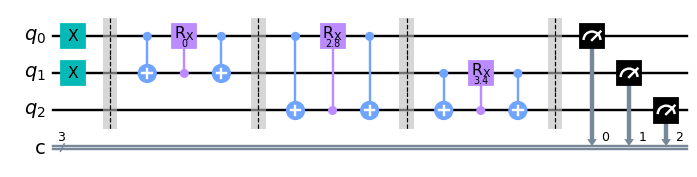

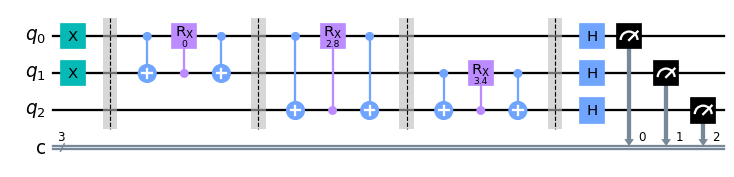

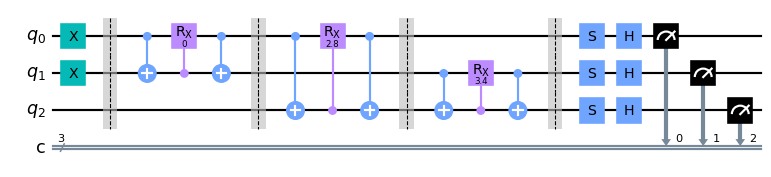

In [11]:
fig,ax = plt.subplots(figsize=(20,3)); cirZ.draw('mpl', ax=ax); plt.show()
fig,ax = plt.subplots(figsize=(20,3)); cirX.draw('mpl', ax=ax); plt.show()
fig,ax = plt.subplots(figsize=(20,3)); cirY.draw('mpl', ax=ax); plt.show()

<div class="alert alert-warning"><h3>  Minimize Etrial manually (some factors and signs may be wrong)  </h3></div>

In [19]:
#================ Run this code first
def findEtrial (B01,B02,B12):
  cir = qiskit.QuantumCircuit(3,3)
  #======== Put two bosons into the system, making a Fock state (c.f. Hartree-Fock)
  cir.x(0)
  cir.x(1)  
  cir.barrier()
  #======== Apply gate sequences representing orbital-orbital boson hopping
  i,j=0,1; cir.cx(i,j); cir.crx(2*B01, j,i); cir.cx(i,j); cir.barrier()
  i,j=0,2; cir.cx(i,j); cir.crx(2*B02, j,i); cir.cx(i,j); cir.barrier()
  i,j=1,2; cir.cx(i,j); cir.crx(2*B12, j,i); cir.cx(i,j); cir.barrier()
  #======== Construct circuits to measure Z, X, and Y components of each qubit
  cirZ = cir.copy(); cirZ.measure ([0,1,2],[0,1,2])
  cirX = cir.copy(); [cirX.h(i) for i in range(3)]; cirX.measure (range(3),range(3))
  cirY = cir.copy(); [cirY.s(i) for i in range(3)]; [cirY.h(i) for i in range(3)]; cirY.measure (range(3),range(3));
  #======== Do the measurements
  sim = qiskit.Aer.get_backend('aer_simulator_statevector')
  ctsX = sim.run(qiskit.transpile(cirX,sim),shots=10000).result().get_counts(cir)
  ctsY = sim.run(qiskit.transpile(cirY,sim),shots=10000).result().get_counts(cir)
  ctsZ = sim.run(qiskit.transpile(cirZ,sim),shots=10000).result().get_counts(cir)
  def computeStats (cts, symmetric=False):
    C = 0                  # total count
    Ci = np.zeros(3)       # averages
    Cij = np.zeros([3,3])  # correlations
    for key in cts:
      state = key
      count = cts[key]
      ni = np.array([int(c) for c in state]) [::-1]  #  0 or  1 (if |0> or |1>)
      if symmetric: ni = 1 - 2*ni                    # +1 or -1 (as in Z component of spin)
      C += count
      Ci += count * ni
      Cij += count * np.outer(ni,ni)
    return Ci/C,Cij/C
  Xi,XiXj = computeStats (ctsX, symmetric=True)
  Yi,YiYj = computeStats (ctsY, symmetric=True)
  Ni,NiNj = computeStats (ctsZ, symmetric=False)
  np.set_printoptions(precision=2,suppress=True)
  EE = E0*Ni[0] + E1*Ni[1] + E2*Ni[2]
  EV = V01*NiNj[0,1] + V02*NiNj[0,2] + V12*NiNj[1,2]
  EX = J01*XiXj[0,1] + J02*XiXj[0,2] + J12*XiXj[1,2]
  EY = J01*YiYj[0,1] + J02*YiYj[0,2] + J12*YiYj[1,2]
  EX *= -1
  EY *= -1
  Etrial = EE + EV + EX + EY
  return Etrial

In [58]:
#================ Try various values of parameters and see Etrial!
print (findEtrial (0  , 0  , 0))
print (findEtrial (0  , 0  , 1.0))
print (findEtrial (0  , 0  , 1.5))  # lowest
print (findEtrial (0  , 0  , 2.0))
print (findEtrial (0  , 0  , 2.5))
print (findEtrial (0  , 0  , 3.0))

15.863
13.020000000000001
12.0738
12.48
14.4816
16.043799999999997


In [59]:
print (findEtrial (0  , 0  , 1.5))
print (findEtrial (0  , 0.2, 1.5))  
print (findEtrial (0  , 0.4, 1.5))  
print (findEtrial (0  , 0.6, 1.5))  
print (findEtrial (0  , 0.7, 1.5))  # lowest
print (findEtrial (0  , 0.8, 1.5))  
print (findEtrial (0  , 0.9, 1.5))  

11.9064
8.299800000000001
5.282300000000001
3.5624000000000002
3.4918000000000005
3.5119000000000016
4.2414999999999985


In [60]:
print (findEtrial (0  , 0.7, 1.5))
print (findEtrial (1. , 0.7, 1.5))
print (findEtrial (2. , 0.7, 1.5)) # no effect

3.5890999999999984
3.4574000000000025
3.4621000000000013


Our conclusion is that the ground-state energy (in the 2-boson sector) is less than or equal to 3.4, and that the optimal parameters in the trial form

$\hspace{1cm}$$\begin{align}
    \ket{\psi} &=
        e^{ i\beta_{12} (a_1^\dagger a_2 + a_2^+ a_1) }
        e^{ i\beta_{02} (a_0^+ a_2 + a_2^+ a_0) }
        e^{ i\beta_{01} (a_0^+ a_1 + a_1^+ a_0) }
        \ket{011}
        ,\\
    \ket{011} &= \adag_1 \adag_0 \ket{000}
    \end{align}$

are close to $\{\beta\} = (0, 0.7, 1.5)$.

<div class="alert alert-warning"><h3>  Toy problem with 3 bosons in 6 orbitals (challenge problem)  </h3></div>

Suppose there are 3 hard-core bosons on a hexagon of 6 orbitals, with nearest-neighbor hopping $J=1$ and nearest-neighbor repulsion $V=1$.   What is the nearest-neighbor correlation $\mean{n_0n_1}$?

The total number of states in the Hilbert space is $2^6 = 64$.  One may compute the $64\times 64$ Hamiltonian matrix and calculate its eigenvalues by brute force.

The number of states with exactly 3 bosons is $\pmatrix{6\\3}=20$.  One may compute the $20\times 20$ Hamiltonian matrix within this subspace and calculate its eigenvalues by brute force.

We may attack this using VQE as follows.

- Choose initial guesses for variational parameters $\beta_{ij}$ (for as many pairs of orbitals $ij$ as you wish).
- Repeat the following many times to gather statistics and estimate $\mean{n_i}$ and $\mean{n_in_j}$:
    - Start from |000000>
    - Apply Hadamard to get         |000000>+|100000>
    - Apply NOT and CNOTs to get    |010101>+|101010>
    - Construct trial state $\ket{\Psi}$ by applying unitary operator $e^{ i\beta_{ij} (a_i^+ a_j + a_j^+ a_i) }$ for every $\beta_{ij}$ above
    - Measure $n_i$ for $i=0,1,2,3,4,5$
    - Repeat many times
- Repeat the following many times to gather statistics and estimate $\mean{X_iX_j}$:
    - Prepare $\ket{\Psi}$ as before
    - Apply Hadamard gate to every qubit to rotate X direction to Z direction
    - Measure every qubit in computational basis to obtain $X_0, \dots, X_5$
- Repeat the following many times to gather statistics and estimate $\mean{Y_iY_j}$:
    - Prepare $\ket{\Psi}$ as before
    - Apply inverse S gate to every qubit to rotate Y direction to X direction
    - Apply Hadamard gate to every qubit to rotate X direction to Z direction
    - Measure every qubit in computational basis to obtain $Y_0, \dots, Y_5$
- Construct $E_\text{trial}$
- Change $\beta_{ij}$ and repeat the whole thing again